In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import scipy.interpolate
import matplotlib.pyplot as plt

# The Black Scholes Formula
# CallorPut
# S - Stock price (known)
# K - Strike price (known)
# T - Time to maturity (known)
# r - Riskfree interest rate (can be found)
# d - Dividend yield (KNown(?))
# v - Volatility (given)

def BlackScholes(CallorPut, S, K, T, r, d, v):
    d1 = (np.log(float(S)/K)+((r-d) + v*v/2.)*T)/(v*np.sqrt(T))
    d2 = d1 - v*np.sqrt(T)
    
    if CallorPut == 'Call':
        return S*np.exp(-d*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*np.exp(-d*T)*norm.cdf(-d1)
    
##THIS WORKS DON'T TOUCH np

#bring in options data 
options = pd.read_csv('opt_port.csv')

opt_list=(0,1,2,3,4,5,6)
options['BS_Price'] = ""

for x in opt_list:
    maturity = (options.iloc[x, 1]/365)
    options.iloc[x, 11] = BlackScholes( options.iloc[x, 4], #callorput
                 options.loc[x, 'Spot'], #spot
                 options.loc[x, 'Strike'], #Strike
                 maturity, # T 
                 options.iloc[x, 2], #RF rate
                 0, #div yield
                 options.iloc[x, 8] #vol
                )
    
options

,Maturity,Days,RF rate,Underlying,PutorCall,BoughtSold,Number of Shares,Strike,Vol,Div Yield,Spot,BS_Price
0,9/12/2019,129,0.010187,BHP,Call,Bought,20000,39.0,0.2600,0.0414,38.78,2.35171
1,8/03/2020,219,0.009705,CBA,Put,Bought,15000,75.0,0.2798,0.0580,81.88,3.70921
2,12/04/2020,254,0.009443,CBA,Call,Bought,15000,75.0,0.2798,0.0580,81.88,11.5326
3,4/05/2020,276,0.009289,WESP,Put,Bought,25000,38.1,0.3056,0.0567,38.86,3.56053
4,7/08/2020,371,0.009026,WESP,Call,Bought,20000,39.0,0.3298,0.0567,38.86,5.22559
5,6/11/2020,462,0.008754,WPL,Call,Sold,10000,35.0,0.2845,0.0603,33.81,3.95955
6,6/12/2020,492,0.008665,WPL,Put,Bought,15000,33.0,0.2700,0.0603,33.81,3.56697


In [3]:
#bring in share data 
sharedata = pd.read_csv('RSKMShares.csv', index_col = 'Date', parse_dates = True)
sharedata.columns = [ 'ASX200', 'BHP', 'RIO', 'CBA', 'WESP', 'WPL', 'NAB', 'TLS']

#Get option data only 
opt_list_name = ('BHP', 'CBA', 'WESP', 'WPL')

Hist_opt_returns = pd.DataFrame()
for x in opt_list_name:
    Hist_opt_returns[x] = sharedata[x]
    
#calc returns
Hist_opt_returns = np.log(Hist_opt_returns).diff()
#drop first row NaN 
Hist_opt_returns = (Hist_opt_returns.drop(Hist_opt_returns.index[0]))

#simulated price change 
Sim_price_change = Hist_opt_returns * [38.78, 81.88, 38.86, 33.81]

#Spot + sim price change 
HS_Sim_Price = Sim_price_change + [38.78, 81.88, 38.86, 33.81]

#add in rows for CBA, WES & WPL as both have 2 options 
HS_Sim_Price.insert(2, 'CBA_2', HS_Sim_Price['CBA'])
HS_Sim_Price.insert(4, 'WESP_2', HS_Sim_Price['WESP'])
HS_Sim_Price.insert(6, 'WPL_2', HS_Sim_Price['WPL'])

HS_Sim_Price.head()

,BHP,CBA,CBA_2,WESP,WESP_2,WPL,WPL_2
Date,,,,,,,
2009-01-02,38.957919,82.725633,82.725633,38.206745,38.206745,34.358267,34.358267
2009-01-05,40.089255,80.180197,80.180197,39.513255,39.513255,34.233375,34.233375
2009-01-06,38.865714,84.333588,84.333588,39.671725,39.671725,34.553687,34.553687
2009-01-07,39.865673,80.422318,80.422318,41.098803,41.098803,33.949827,33.949827
2009-01-08,36.514407,80.769452,80.769452,37.250478,37.250478,31.705231,31.705231


In [4]:
#Historical simulation of option prices 
opt_list=(0,1,2,3,4,5,6)
BS_HS_Sim = pd.DataFrame()
hist = list(range(0, 2760))

for y in hist:
    
    for x in opt_list:
        
        maturity = (options.iloc[x, 1]/365)
        
        BS_HS_Sim.loc[y,x] = BlackScholes( options.iloc[x, 4], #callorput
                 HS_Sim_Price.iloc[y, x], #spot
                 options.loc[x, 'Strike'], #Strike
                 maturity, # T 
                 options.iloc[x, 2], #RF rate
                 0, #div yield
                 options.loc[x, 'Vol'] #vol
                )
BS_HS_Sim

,0,1,2,3,4,5,6
0,2.446252,3.467005,12.129910,3.834924,4.858059,4.258076,3.356863
1,3.095551,4.238599,10.371696,3.302173,5.606069,4.189114,3.403782
2,2.396992,3.042967,13.300139,3.241859,5.700283,4.367107,3.284547
3,2.960766,4.159612,10.533701,2.738521,6.581284,4.034643,3.512361
4,1.334268,4.048473,10.767940,4.266519,4.344095,2.917843,4.477595
5,3.017202,3.511919,12.015580,3.338991,5.549606,3.738196,3.735369
6,1.823648,4.133280,10.588525,4.442162,4.154270,3.819615,3.672088
7,2.094117,3.650088,11.674132,4.049360,4.593705,3.497313,3.932437
8,2.704129,3.683844,11.592978,4.044276,4.599760,4.424225,3.247543
9,1.197717,4.778065,9.354171,4.462283,4.133170,3.174793,4.222129


In [5]:
HS_MtM = BS_HS_Sim * options['Number of Shares']
HS_MtM[5] = HS_MtM[5].apply(lambda x: x*-1)
HS_MtM

,0,1,2,3,4,5,6
0,48925.030922,52005.073005,181948.645089,95873.111069,97161.180683,-42580.764355,50352.942258
1,61911.018196,63578.985577,155575.438007,82554.329100,112121.386878,-41891.143798,51056.722705
2,47939.846000,45644.498610,199502.084260,81046.470251,114005.652578,-43671.065043,49268.206305
3,59215.329569,62394.184269,158005.520705,68463.030869,131625.670763,-40346.427240,52685.408768
4,26685.360312,60727.091481,161519.093304,106662.975225,86881.897276,-29178.431565,67163.922990
5,60344.045416,52678.782538,180233.701333,83474.777133,110992.111365,-37381.961301,56030.534851
6,36472.961705,61999.194859,158827.871000,111054.060681,83085.404627,-38196.152427,55081.323285
7,41882.347862,54751.324743,175111.987252,101234.011449,91874.107065,-34973.133559,58986.552394
8,54082.574710,55257.660670,173894.670083,101106.907665,91995.197155,-44242.250768,48713.141645
9,23954.347865,71670.971689,140312.564664,111557.079781,82663.406079,-31747.930429,63331.929241


In [6]:
PnL = pd.DataFrame(HS_MtM.sum(axis=1) - 483061.91)
PnL

,0
0,623.308671
1,1844.826665
2,10673.782961
3,8980.807703
4,-2600.000977
5,23310.081335
6,-14737.246271
7,5805.287205
8,-2254.008841
9,-21319.541110


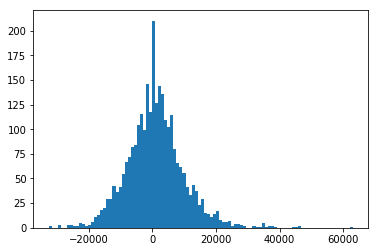

In [7]:
HPnL = np.array(PnL)
HPnL.sort
plt.hist(HPnL, bins=100);
option_var = np.percentile(HPnL, 5)

In [8]:
#historical Sim of shares 

share_list_name = ('BHP', 'RIO', 'CBA', 'WESP', 'WPL', 'NAB', 'TLS')

Hist_share_returns = pd.DataFrame()
for x in share_list_name:
    Hist_share_returns[x] = sharedata[x]
    
#calc returns
Hist_share_returns = np.log(Hist_share_returns).diff()
#drop first row NaN 
Hist_share_returns = (Hist_share_returns.drop(Hist_share_returns.index[0]))

#simulated price change 
Sim_price_change = Hist_share_returns * [38.78,94.77,81.88,38.86,33.81,28.51,3.98]

#Spot + sim price change 
HS_Sim_Price = Sim_price_change + [38.78,94.77,81.88,38.86,33.81,28.51,3.98]

#Short poitions
shorts = ['WESP', 'NAB', 'TLS']

for y in shorts:
    HS_Sim_Price[y] = HS_Sim_Price[y].apply(lambda x: x*-1)

#Portfolio 
HS_Port = HS_Sim_Price * [5000,3000,4000,10000,5000,15000,30000]
#Sim portfolio - portfolio 
PnL_stock = pd.DataFrame(HS_Port.sum(axis=1)- 39130)

In [9]:
PnL_stock
PnL_stock.to_excel (r'C:\Users\Mat\Documents\HS_port4_stock_price.xlsx', index = None, header=True)

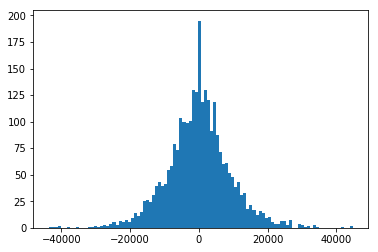

In [10]:
HPnL_stock = np.array(PnL_stock)
HPnL_stock.sort
plt.hist(HPnL_stock, bins=100);
stock_var = np.percentile(HPnL_stock, 5)

In [11]:
stock_var + option_var

-27899.985670686903

In [12]:
option_var

-12903.100985634243

In [13]:
stock_var

-14996.88468505266

In [14]:
np.percentile(HPnL, 1) + np.percentile(HPnL_stock, 1)

-43646.17048650778

In [15]:
HPnL[HPnL <= np.percentile(HPnL, 5)].mean() + HPnL_stock[HPnL_stock <= np.percentile(HPnL_stock, 5)].mean()

-37690.62324269231

In [16]:
np.percentile(HPnL_stock, 1)

-24138.2853393692